In [1]:
# dependencies import
from common_dependencies import *

from matplotlib import ticker
from matplotlib.patches import Polygon as mplPolygon
from shapely.geometry import Polygon as shPolygon
from shapely.ops import unary_union

from docx.enum.section import WD_ORIENT
from docx import Document
from docx.shared import Inches, Cm
from docx.shared import Pt
from docx.shared import RGBColor

from typing import NamedTuple

In [2]:
PATH_TO_GET_DATA = 'data\\drawing_data'
PATH_TO_SAVE_DATA = 'data\\report'
MODEL_VERS = [] # для каких версий моделей делать отчет
MODEL_NUMS = [] # для каких номеров моделей делать отчет

model_runs = r'\d{2}' if len(MODEL_VERS) == 0 else f"({'|'.join([model_ver for model_ver in MODEL_VERS])})"
model_nums = r'\d{2}' if len(MODEL_NUMS) == 0 else f"({'|'.join([model_num for model_num in MODEL_NUMS])})"
# пути к каким версиям и номерам моделей учитывать при создании отчетов
model_folder_regex = r'.*\\model_id=' + f'v{model_runs}n{model_nums}$'
run_folder_regex = model_folder_regex[:-1] + r'\\run_\d+$'

In [3]:
def decrease_blur(df_cell_value):
    res = 1-(2*(1-df_cell_value)**2) if df_cell_value <= 0.5 else 2*df_cell_value**2
    return res

In [5]:
def save_df_as_jpg(df: pd.DataFrame, label: str, path: str):
    fig, ax = plt.subplots()

    fig.set_figwidth(18)
    fig.set_figheight(8)
    fig.patch.set_alpha(0.0)

    ax.invert_yaxis()
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    ax.set_title(label, fontsize=25)
    ax.set_xlabel('Номер датчика', fontsize=20)
    ax.set_ylabel('Номер измерения', fontsize=20)
    ax.tick_params(axis='both', labelsize = 20)
    
    map = ax.pcolormesh(df)
    cbar = fig.colorbar(map)
    cbar.ax.tick_params(labelsize=20)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(60))

    plt.savefig(path, bbox_inches='tight')
    plt.close()

In [6]:
def save_df_as_jpg_with_owerlap(pred_df: pd.DataFrame,
                                ref_df: pd.DataFrame,
                                label: str, path: str):
    fig, ax = plt.subplots()

    fig.set_figwidth(18)
    fig.set_figheight(8)
    fig.patch.set_alpha(0.0)

    ax.invert_yaxis()
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    ax.set_title(label, fontsize=25)
    ax.set_xlabel('Номер датчика', fontsize=20)
    ax.set_ylabel('Номер измерения', fontsize=20)
    ax.tick_params(axis='both', labelsize = 20)
    
    map = ax.pcolormesh(pred_df)
    cbar = fig.colorbar(map)
    cbar.ax.tick_params(labelsize=20)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(60))

    # Get pixel position above the threshold
    Y, X = np.where(ref_df.to_numpy() > 0)
    positions = np.dstack((X, Y))[0]
    
    # Create a rectangle per position and merge them.
    rectangles = [shPolygon([xy, xy + [1, 0], xy + [1, 1], xy + [0, 1]]) for xy in positions]
    polygons = unary_union(rectangles)
    
    # Shapely will return either a Polygon or a MultiPolygon. 
    # Make sure the structure is the same in any case.
    if polygons.geom_type == "Polygon":
        polygons = [polygons]
    else:
        polygons = polygons.geoms
    
    # Add the matplotlib Polygon patches
    for polygon in polygons:
        ax.add_patch(mplPolygon(polygon.exterior.coords, fc='crimson'))
    
    plt.savefig(path, bbox_inches='tight')
    plt.close()

Current working path:  data\drawing_data\model_id=v02n01\run_1
model_id=v02n01_crop(size=16,step=1)_shift(x=200,y=0).xlsx  processing...
model_id=v02n01_crop(size=16,step=16)_shift(x=200,y=0).xlsx  processing...
model_id=v02n01_crop(size=16,step=2)_shift(x=200,y=0).xlsx  processing...
model_id=v02n01_crop(size=16,step=4)_shift(x=200,y=0).xlsx  processing...
model_id=v02n01_crop(size=16,step=8)_shift(x=200,y=0).xlsx  processing...

Current working path:  data\drawing_data\model_id=v02n01\run_2
model_id=v02n01_crop(size=16,step=1)_shift(x=200,y=0).xlsx  processing...
model_id=v02n01_crop(size=16,step=16)_shift(x=200,y=0).xlsx  processing...
model_id=v02n01_crop(size=16,step=2)_shift(x=200,y=0).xlsx  processing...
model_id=v02n01_crop(size=16,step=4)_shift(x=200,y=0).xlsx  processing...
model_id=v02n01_crop(size=16,step=8)_shift(x=200,y=0).xlsx  processing...

Current working path:  data\drawing_data\model_id=v02n02\run_1
model_id=v02n02_crop(size=16,step=1)_shift(x=200,y=0).xlsx  process

KeyboardInterrupt: 

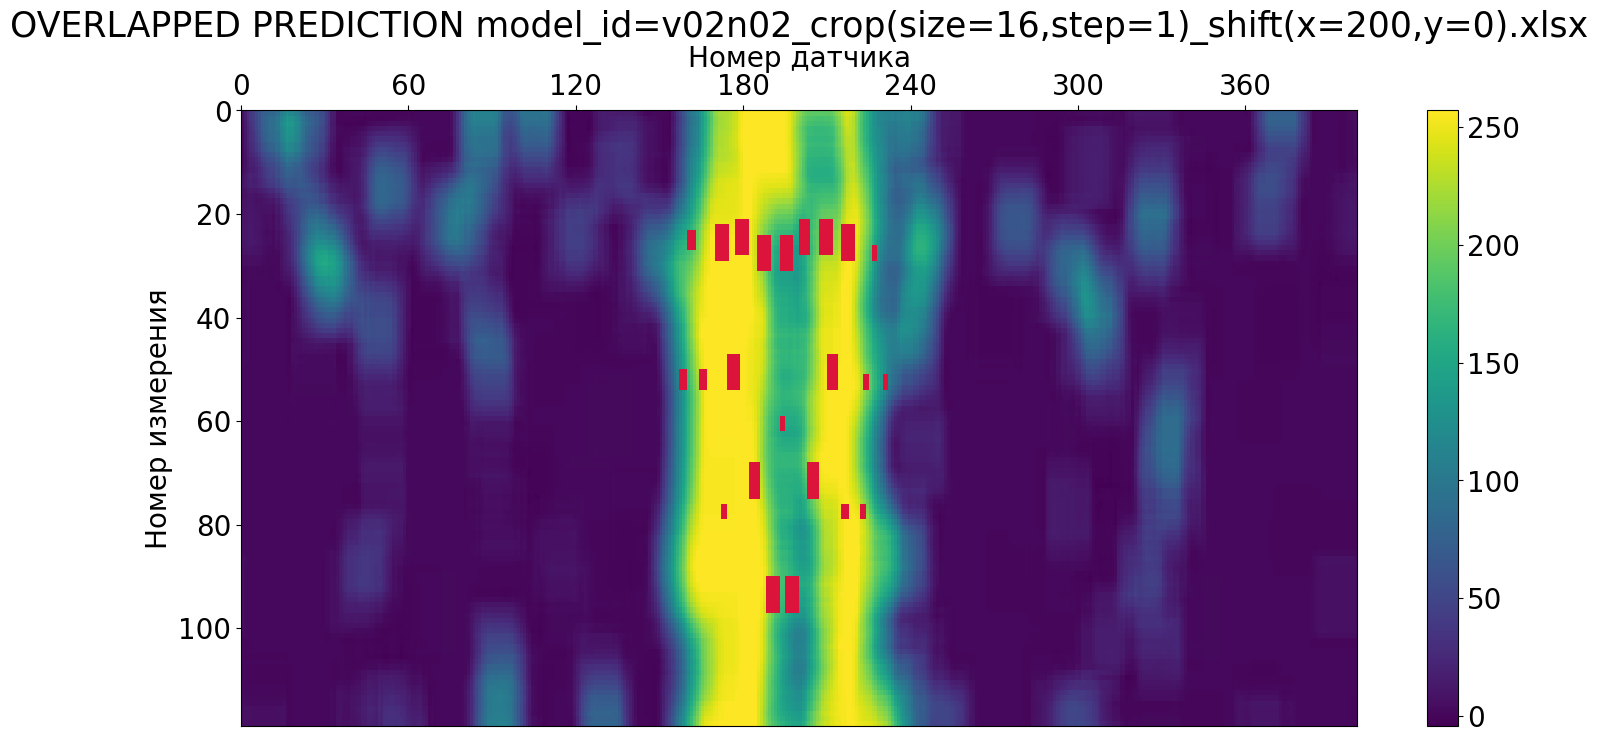

In [7]:
# create temp folder "report" in 'PATH_TO_DATA' parent folder
# with identical folder tree structure as 'PATH_TO_DATA'
# and fill every folder with jpgs instead of .xlsx files

# BLUR ONES

for run_path in os.walk(PATH_TO_GET_DATA):
    ref = True
    if re.match(run_folder_regex, run_path[0]) is None:
        continue

    full_path_to_save_run_files = run_path[0].replace(PATH_TO_GET_DATA, PATH_TO_SAVE_DATA)
    
    if not os.path.exists(full_path_to_save_run_files):
        os.makedirs(full_path_to_save_run_files)
    
    print('Current working path: ',run_path[0])
    for file_name in run_path[2]:
        if re.match('.*\.xlsx', file_name) is None:
            continue
        print(file_name, ' processing...')
        
        if ref == True:
            ref_df = pd.read_excel(os.path.join(run_path[0], file_name),
                         sheet_name='orig_reference', index_col=0, dtype=np.float64)
            save_df_as_jpg(ref_df, 'REFERENCE ' + file_name,
                os.path.join(full_path_to_save_run_files, 'REFERENCE ' + file_name + '.jpg'))
            ref = False
            
        pred_df = pd.read_excel(os.path.join(run_path[0], file_name),
                      sheet_name='orig_res', index_col=0, dtype=np.float64)
        
        save_df_as_jpg(pred_df, 'PREDICTION ' + file_name,
            os.path.join(full_path_to_save_run_files, 'PREDICTION ' + file_name + '.jpg'))
        
        save_df_as_jpg_with_owerlap(pred_df, ref_df, 'OVERLAPPED PREDICTION ' + file_name,
            os.path.join(full_path_to_save_run_files, 'OVERLAPPED PREDICTION ' + file_name + '.jpg'))

        pred_df1 = pred_df.map(decrease_blur)

        save_df_as_jpg(pred_df1, 'UNBLUR PREDICTION ' + file_name,
            os.path.join(full_path_to_save_run_files, 'UNBLUR PREDICTION ' + file_name + '.jpg'))
        
        save_df_as_jpg_with_owerlap(pred_df1, ref_df, 'UNBLUR OVERLAPPED PREDICTION ' + file_name,
            os.path.join(full_path_to_save_run_files, 'UNBLUR OVERLAPPED PREDICTION ' + file_name + '.jpg'))
        
    print()

In [ ]:
ImageDescription = NamedTuple("ImageDescription", 
                                  [('model_id', str), 
                                   ('run_num', int),
                                   ('image_type_name', str),
                                   ('crop_step', int),
                                   ('path', str)])
image_descriptions_list = []


for run_path in os.walk(PATH_TO_SAVE_DATA):
    if re.search(run_folder_regex, run_path[0]) is None:
        continue
    model_id = re.findall(r'model_id=(v\d{2}n\d{2})', run_path[0])[0]
    run_num = re.findall(r'run_(\d+)', run_path[0])[0]
    for image_name in os.listdir(run_path[0]):
        if re.match('.*\.jpg', image_name) is None:
            continue

        crop_step = re.findall(r'step=(\d+)', image_name)[0]
        image_type_name = re.search(r'[A-Z\s]+', image_name)[0].strip()
        image_descriptions_list.append(ImageDescription(model_id, 
                                                        int(run_num), 
                                                        image_type_name, 
                                                        int(crop_step),
                                                        os.path.join(run_path[0], image_name)))
        #print(os.path.join(run_path[0], image_name))

In [ ]:
IMAGE_WIDTH = 8
for model_path in os.walk(PATH_TO_SAVE_DATA):
    if re.match(model_folder_regex, model_path[0]) is None:
        continue
    model_id = re.findall(r'model_id=(v\d{2}n\d{2})', model_path[0])[0]
    # images related to current model
    model_images = [image_desc for image_desc in image_descriptions_list if image_desc.model_id == model_id]
    # numbers of "run_"
    run_numbers = list(set([image_desc.run_num for image_desc in model_images]))
    run_numbers.sort()
    
    document = Document()
    document.add_heading(f'MODEL_ID={model_id} PREDICTION RESULTS', 0)

    for run in run_numbers:
        ref_image = [image_desc for image_desc in model_images 
                     if image_desc.run_num == run and image_desc.image_type_name == 'REFERENCE']

        
        pred_images = [image_desc for image_desc in model_images 
                     if image_desc.run_num == run and image_desc.image_type_name == 'PREDICTION']
        pred_images.sort(key=lambda x: x.crop_step, reverse=True)

        unblur_pred_images = [image_desc for image_desc in model_images 
                 if image_desc.run_num == run and image_desc.image_type_name == 'UNBLUR PREDICTION']
        unblur_pred_images.sort(key=lambda x: x.crop_step, reverse=True)

        
        overlapped_pred_images = [image_desc for image_desc in model_images 
                     if image_desc.run_num == run and image_desc.image_type_name == 'OVERLAPPED PREDICTION']
        overlapped_pred_images.sort(key=lambda x: x.crop_step, reverse=True)

        unblur_overlapped_pred_images = [image_desc for image_desc in model_images 
                     if image_desc.run_num == run and image_desc.image_type_name == 'UNBLUR OVERLAPPED PREDICTION']
        unblur_overlapped_pred_images.sort(key=lambda x: x.crop_step, reverse=True)
    
        
        document.add_heading(f'RUN {run}', 1)
        document.add_heading('REFERENCE', 2)
        document.add_picture(ref_image[0].path, width=Inches(IMAGE_WIDTH))
        
        document.add_heading('MODEL PREDICTION', 2)
        for image_desc in pred_images:
            document.add_picture(image_desc.path, width=Inches(IMAGE_WIDTH))

        document.add_heading('UNBLUR MODEL PREDICTION', 2)
        for image_desc in unblur_pred_images:
            document.add_picture(image_desc.path, width=Inches(IMAGE_WIDTH))
        
        document.add_heading('OVERLAPPED WITH REFERENCE MODEL PREDICTION', 2)
        for image_desc in overlapped_pred_images:
            document.add_picture(image_desc.path, width=Inches(IMAGE_WIDTH))

        document.add_heading('UNBLUR OVERLAPPED WITH REFERENCE MODEL PREDICTION', 2)
        for image_desc in unblur_overlapped_pred_images:
            document.add_picture(image_desc.path, width=Inches(IMAGE_WIDTH))
        
        document.add_page_break()
        
    section = document.sections[-1]
    
    #new_width, new_height = section.page_height, section.page_width
    #section.orientation = WD_ORIENT.LANDSCAPE
    #section.page_width = new_width
    #section.page_height = new_height
    
    section.top_margin = Cm(0.5)
    section.bottom_margin = Cm(0.5)
    section.left_margin = Cm(0.5)
    section.right_margin = Cm(0.5)

    head0_style = document.styles['Title']
    head1_style = document.styles['Heading 1']
    head2_style = document.styles['Heading 2']

    head0_style.font.size = Pt(24)
    head1_style.font.size = Pt(22)
    head2_style.font.size = Pt(20)
    
    head0_style.font.color.rgb = RGBColor(255, 0, 0)
    head1_style.font.color.rgb = RGBColor(255, 0, 0)
    head2_style.font.color.rgb = RGBColor(255, 0, 0)
    
    document.save(os.path.join(model_path[0], 'report.docx'))